# 1. Data loading and preprocessing

### 1.1 Load all the libraries including OpenAI

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install --upgrade openai

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.0 MB 2.0 MB/s eta 0:00:01
   ------------- -------------------------- 0.3/1.0 MB 5.5 MB/s eta 0:00:01
   -------------------------- ------------- 0.7/1.0 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 2.6.1
    Uninstalling openai-2.6.1:
      Successfully uninstalled openai-2.6.1


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
from openai import OpenAI

In [4]:
import openai
print(openai.__version__)

2.7.1


### 1.2 Test connection to OpenAI

In [5]:
client = OpenAI(api_key="INSERT YOUR KEY HERE")

In [6]:
# Making a simple request to test connectivity
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "Say hello in one short sentence."}
    ]
)

# Printing the model's reply
print(response.choices[0].message.content)

Hello!


### 1.3 Load the original data and the results data and create pandas dataframes for them

In [7]:
with open("booking_reviews_678_varlen_clean.json", "r") as f:
    raw_data = json.load(f)

with open("results_booking_reviews_678_varlen_clean.json", "r") as f:
    results_data = json.load(f)

# Creating a pandas dataframe for raw data/ tickets
df_raw = pd.DataFrame(raw_data["tickets"])
df_raw.head()

,original_message,message_text,sentiment__filter
0,"Not to gush, but support has genuinely helped ...","not to gush, but support has genuinely helped ...",Positive
1,"Over the weekend, the rewards points actually ...","over the weekend, the rewards points actually ...",Positive
2,"Not to gush, but support has genuinely helped ...","not to gush, but support has genuinely helped ...",Positive
3,"While traveling abroad, the app froze twice on...","while traveling abroad, the app froze twice on...",Negative
4,"For a family visit, the property was overbooke...","for a family visit, the property was overbooke...",Negative


In [8]:
# Creating a pandas dataframe for original given results. I take only first list out of 5 (first 4 are copies of each other)
df_results = pd.DataFrame(results_data["gemini-2.5-flash"][0])
df_results.head(10)

,subtopic,search_query,percent,sentiment,examples
0,Unexpected Charges & Pricing,price changed + hidden fees + promo code faile...,15,Negative,"[price changed at payment, fees appeared at ch..."
1,App Stability & Performance,app froze + crashing + app lags + search slow ...,10,Negative,"[app froze twice on the payment screen, keeps ..."
2,Property & Booking Discrepancies,room type changed + property overbooked + filt...,12,Negative,"[room type changed without notice, property wa..."
3,Customer Support Issues,support slow + support took days + support was...,7,Negative,[support took days to respond to a simple ques...
4,Notifications & Advertising,notifications ads + pushing ads + ads annoying...,5,Negative,[notifications kept pushing ads despite being ...
5,Ease of Booking & Confirmation,excellent app + works flawlessly + super simpl...,25,Positive,"[excellent app, no issues, works flawlessly fo..."
6,Effective Customer Support,customer support answered + support helped + l...,8,Positive,"[customer support answered within minutes, fix..."
7,Clear Cancellation Policy,cancellation policy clear + fair cancellation,5,Positive,"[cancellation policy was clear and fair, cance..."
8,Interface & Navigation,interface dated + app lags + maps helped + sea...,13,Neutral,"[interface is okay but looks dated, app lags w..."


In [9]:
# Adding a column to raw dataframe with indices, neccessary later
df_raw["id"] = df_raw.index

# Creating a list of topics (9 subtopics) from original results dataframe, necessary later for Chat GPT processing
TOPICS = list(dict.fromkeys(df_results['subtopic'].tolist()))
print(TOPICS)

['Unexpected Charges & Pricing', 'App Stability & Performance', 'Property & Booking Discrepancies', 'Customer Support Issues', 'Notifications & Advertising', 'Ease of Booking & Confirmation', 'Effective Customer Support', 'Clear Cancellation Policy', 'Interface & Navigation']


# 2. Reprocessing of tickets using OpenAI and provided key for validation

## 2.1 Calling ChatGPT, sending prompt, data in batches and writing the results in json file

We run over tickets and ask ChatGPT to classify it into one of 9 subtopics, plus add a sentiment. We are saving the results into a new json file externally.

In [10]:
import os

# Output file
output_file = "gpt_classification_results.json"
if os.path.exists(output_file):
    os.remove(output_file)

batch_size = 50
all_results = []

for i in range(0, len(df_raw), batch_size):
    batch = df_raw.iloc[i:i+batch_size]
    print(f"\nProcessing batch {i//batch_size + 1} ({len(batch)} messages)...")

    # Convert topics list to string format for prompt
    topics_str = json.dumps(TOPICS)  # ensures proper JSON formatting

    # Build the prompt dynamically
    prompt = f"""
You are a classifier. For each text below, assign:

- subtopic: one of the following {topics_str}

- sentiment: Positive, Neutral, or Negative

Respond **only** with a JSON array of objects with fields: id, subtopic, sentiment.
Do NOT include explanations, extra text, or code blocks.

Example:
[
  {{"id": 0, "subtopic": "Interface & Navigation", "sentiment": "Positive"}},
  {{"id": 1, "subtopic": "Customer Support Issues", "sentiment": "Negative"}}
]
"""

    # Add each message to the prompt
    for idx, row in batch.iterrows():
        prompt += f'\n{{"id": {idx}, "text": "{row["message_text"]}"}}'

    # Call Chat GPT
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # or gpt-5 if available
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    # Get Chat GPT output
    raw = response.choices[0].message.content

    # Try to parse JSON; if it fails, save raw string instead
    try:
        batch_json = json.loads(raw)
    except json.JSONDecodeError:
        print("JSON parse error — saving raw response as string")
        batch_json = [{"raw_response": raw}]

    # Append batch results to all_results
    all_results.extend(batch_json)

    # Save progress after each batch
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(all_results, f, indent=2, ensure_ascii=False)

print(f"\n All batches processed and saved to {output_file}")



Processing batch 1 (50 messages)...

Processing batch 2 (50 messages)...

Processing batch 3 (50 messages)...

Processing batch 4 (50 messages)...

Processing batch 5 (50 messages)...

Processing batch 6 (50 messages)...

Processing batch 7 (50 messages)...

Processing batch 8 (50 messages)...

Processing batch 9 (50 messages)...

Processing batch 10 (50 messages)...

Processing batch 11 (50 messages)...

Processing batch 12 (50 messages)...

Processing batch 13 (50 messages)...

Processing batch 14 (28 messages)...

 All batches processed and saved to gpt_classification_results.json


## 2.2 Uploade results from just saved json file, create pandas dataframe for processing them

In [11]:
# Load JSON file
with open("gpt_classification_results.json", "r", encoding="utf-8") as f:
    gpt_results_data = json.load(f)

# Create DataFrame
df_gpt_results = pd.DataFrame(gpt_results_data)

# Keep only the relevant columns (in case there are extra fields)
df_gpt_results = df_gpt_results[["id", "subtopic", "sentiment"]]

df_gpt_results.head()

,id,subtopic,sentiment
0,0,Effective Customer Support,Positive
1,1,Clear Cancellation Policy,Positive
2,2,Effective Customer Support,Positive
3,3,App Stability & Performance,Negative
4,4,Property & Booking Discrepancies,Negative


In [12]:
df_gpt_results.shape

(678, 3)

# 3. Validate volume for each topic

### Comparing percent of tickets per topic from the original results data vs My GPT Classification

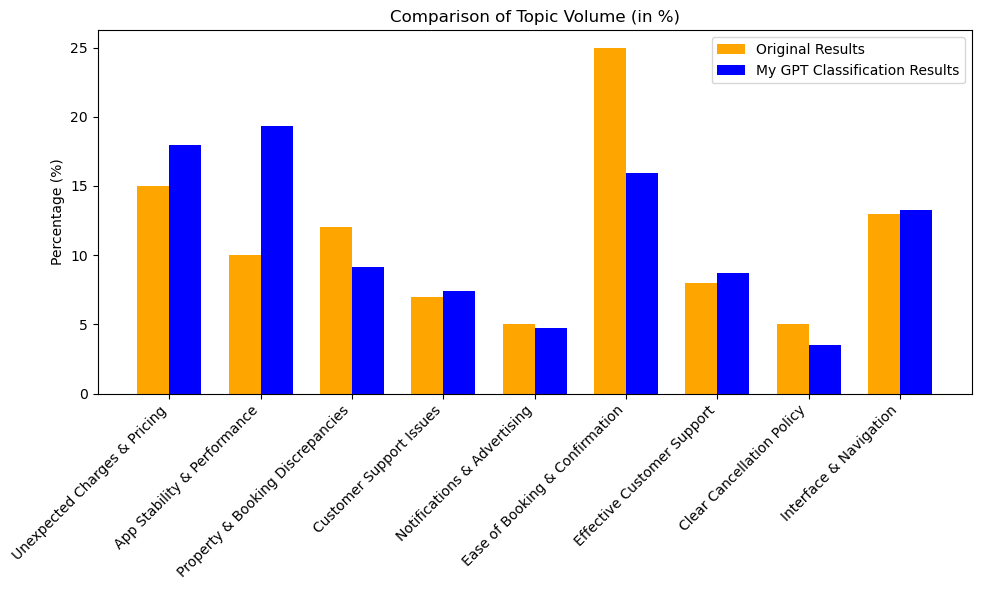

In [13]:
# Calculating percentage distribution for My GPT results
category_counts = df_gpt_results['subtopic'].value_counts()
category_percent = (category_counts / len(df_gpt_results)) * 100
category_percent = category_percent.reset_index()
category_percent.columns = ['subtopic', 'gpt_percent']

# Getting the original results (already in percent)
df_results_percent = df_results[['subtopic', 'percent']].drop_duplicates()

# Merging them together on subtopic
comparison_df = pd.merge(df_results_percent, category_percent, on='subtopic', how='inner')

# Plotting side-by-side bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(comparison_df))

plt.bar(
    [i - bar_width/2 for i in x],
    comparison_df['percent'],
    width=bar_width,
    color='orange',
    label='Original Results'
)

plt.bar(
    [i + bar_width/2 for i in x],
    comparison_df['gpt_percent'],
    width=bar_width,
    color='blue',
    label='My GPT Classification Results'
)

plt.xticks(x, comparison_df['subtopic'], rotation=45, ha='right')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Topic Volume (in %)')
plt.legend()
plt.tight_layout()
plt.show()


# 4. Validate sentiment for each topic

### 4.1 First, let's visualize how sentiment is distributed in each subtopic in My GPT Classification

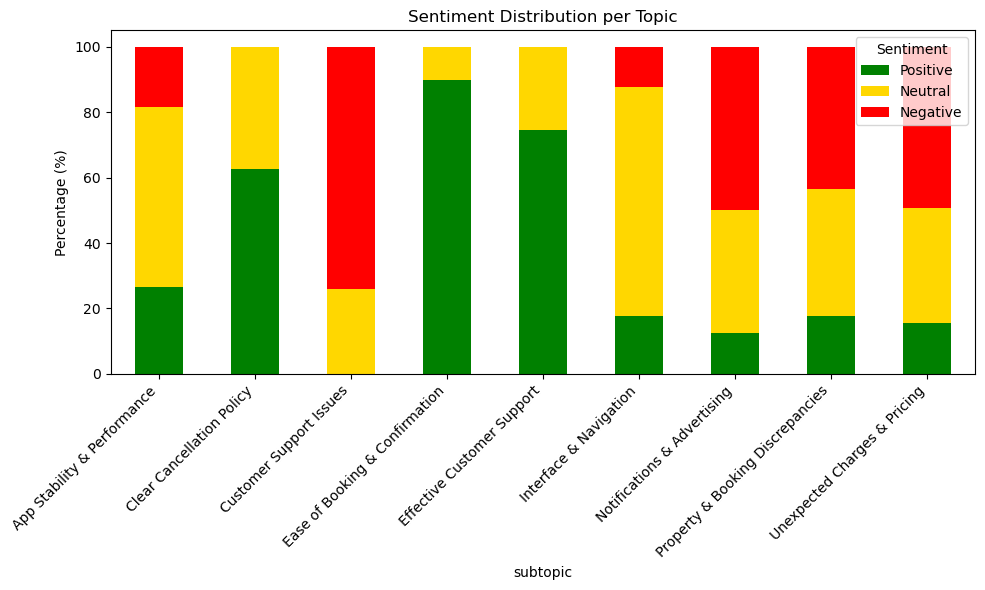

In [14]:
# 1. Calculating sentiment distribution (counts and percentages)
sentiment_dist = (
    df_gpt_results.groupby(['subtopic', 'sentiment'])
    .size()
    .unstack(fill_value=0)
)

# Converting to percentage (within each subtopic)
sentiment_percent = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0) * 100

# 2. Plotting stacked bar chart
colors = {
    'Positive': 'green',
    'Neutral': 'gold',
    'Negative': 'red'
}

sentiment_percent = sentiment_percent[['Positive', 'Neutral', 'Negative']]  # ensure consistent order

sentiment_percent.plot(
    kind='bar',
    stacked=True,
    color=[colors['Positive'], colors['Neutral'], colors['Negative']],
    figsize=(10, 6)
)

plt.ylabel('Percentage (%)')
plt.title('Sentiment Distribution per Topic')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


### 2. Next, we find the most frequent sentiment per subtopic (what we just visualized) and add as a column to df_results dataframe

In [15]:
# 1. Finding the most common (majority) sentiment per subtopic
majority_sentiment = (
    df_gpt_results.groupby('subtopic')['sentiment']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
    .rename(columns={'sentiment': 'my_gpt_sentiment'})
)

# 2. Merging this back into df_results
df_results = df_results.merge(majority_sentiment, on='subtopic', how='left')

df_results.head(10)

,subtopic,search_query,percent,sentiment,examples,my_gpt_sentiment
0,Unexpected Charges & Pricing,price changed + hidden fees + promo code faile...,15,Negative,"[price changed at payment, fees appeared at ch...",Negative
1,App Stability & Performance,app froze + crashing + app lags + search slow ...,10,Negative,"[app froze twice on the payment screen, keeps ...",Neutral
2,Property & Booking Discrepancies,room type changed + property overbooked + filt...,12,Negative,"[room type changed without notice, property wa...",Negative
3,Customer Support Issues,support slow + support took days + support was...,7,Negative,[support took days to respond to a simple ques...,Negative
4,Notifications & Advertising,notifications ads + pushing ads + ads annoying...,5,Negative,[notifications kept pushing ads despite being ...,Negative
5,Ease of Booking & Confirmation,excellent app + works flawlessly + super simpl...,25,Positive,"[excellent app, no issues, works flawlessly fo...",Positive
6,Effective Customer Support,customer support answered + support helped + l...,8,Positive,"[customer support answered within minutes, fix...",Positive
7,Clear Cancellation Policy,cancellation policy clear + fair cancellation,5,Positive,"[cancellation policy was clear and fair, cance...",Positive
8,Interface & Navigation,interface dated + app lags + maps helped + sea...,13,Neutral,"[interface is okay but looks dated, app lags w...",Neutral


### 3. Finally, we visually compare originally assigned sentiments for each topic vs My GPT Classification sentiments

This plot will be the same as the plot in question 1, but colored with the colors of the corresponding sentiment for better comparison

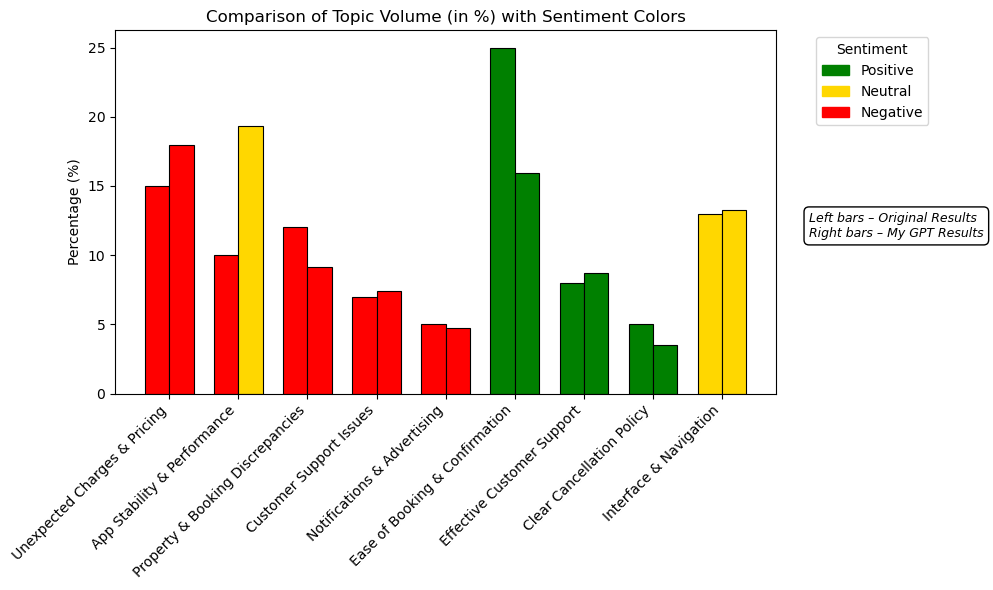

In [16]:
import matplotlib.patches as mpatches

# Defining sentiment colors
sentiment_colors = {
    'Positive': 'green',
    'Neutral': 'gold',
    'Negative': 'red'
}

# Preparing comparison data
comparison_df = df_results[['subtopic', 'percent', 'sentiment', 'my_gpt_sentiment']].copy()

# Computing Chat GPT percent
category_counts = df_gpt_results['subtopic'].value_counts()
category_percent = (category_counts / len(df_gpt_results)) * 100
category_percent = category_percent.reset_index()
category_percent.columns = ['subtopic', 'gpt_percent']

# Merging Chat GPT percentages back into df_results
comparison_df = comparison_df.merge(category_percent, on='subtopic', how='left')

# Plotting setup
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(comparison_df))

# Bar colors by sentiment
orig_colors = [sentiment_colors[s] for s in comparison_df['sentiment']]
gpt_colors = [sentiment_colors[s] for s in comparison_df['my_gpt_sentiment']]

# Original results bars (left)
plt.bar(
    [i - bar_width/2 for i in x],
    comparison_df['percent'],
    width=bar_width,
    color=orig_colors,
    edgecolor='black',
    linewidth=0.8
)

# Chat GPT results bars (right)
plt.bar(
    [i + bar_width/2 for i in x],
    comparison_df['gpt_percent'],
    width=bar_width,
    color=gpt_colors,
    edgecolor='black',
    linewidth=0.8
)

# Axis labels, title, etc.
plt.xticks(x, comparison_df['subtopic'], rotation=45, ha='right')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Topic Volume (in %) with Sentiment Colors')

# Sentiment color legend
legend_patches = [
    mpatches.Patch(color='green', label='Positive'),
    mpatches.Patch(color='gold', label='Neutral'),
    mpatches.Patch(color='red', label='Negative')
]
legend = plt.legend(handles=legend_patches, title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add explanatory box below the legend
plt.text(
    1.05, 0.5,  # position relative to axes
    "Left bars – Original Results\nRight bars – My GPT Results",
    transform=plt.gca().transAxes,
    fontsize=9,
    style='italic',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
    verticalalignment='top'
)

plt.tight_layout()
plt.show()


# 5. Conclusion and discussion of the findings

<br>

1. My findings showed that there is discrepancy between the results, especially in the topics volumes. Personally, I also compared them manually via key words and found discrepancy in assigned %.

   It can be explained that the model assigns multiple topics per ticket (especially for the long ones), but it is hard to say without seeing the model itself, and only the results.
   
   <br>

2. The validation and verification of the accuracy can also include some quantitative estimate like a score, but due to limited information, I chose visual comparison to show disprepancies.

<div style="text-align: right; margin-top: 50px;">
  Completed by Olga Kyzylova
</div>